In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.utils import class_weight

In [3]:
tf.keras.backend.set_floatx('float64')

In [4]:
#Reading all data
df_All_NoAge = pd.read_csv("all_data_no_ages.csv")
df_All_Age = pd.read_csv("all_data_with_ages.csv")
#df_Primary_NoAge = pd.read_csv("primary_data_no_ages.csv")
#df_Primary_Age = pd.read_csv("primary_data_with_ages.csv")

In [5]:
#Create a list of datasets
#datasets_for_modeling = [df_All_NoAge, df_All_Age, df_Primary_NoAge, df_Primary_Age]
datasets_for_modeling = [df_All_Age]
#dataset names
#dataset_names=['df_All_NoAge', 'df_All_Age', 'df_Primary_NoAge', 'df_Primary_Age']
dataset_names=[ 'df_All_Age']

In [6]:
target_base_codes =['E11','N18','I10','I25','C50','C18']

In [7]:
def get_predictor_codes(edges, exclusions, input_code, limit = 20):
    # Function to automatically identify the top *limit* possible predictor ICD10 codes.
    # Inputs:
    # edges = a dataframe of ICD10 Base Code edges and their associated weights that represent how often the nodes co-occur in the same Member Life ID
    # exclusions = list of icd10 Base Codes ignore when selecting predictor variables
    # input_code = the ICD10 Base Code which we are interested in finding associated predictor ICD10 base codes for
    # limit =  the number of predictor ICD10 Base Codes to identify
    filtered_edges = edges.loc[edges['Edge'].str.contains(input_code)].sort_values(by = ['Weight', 'Source', 'Target'], ascending = [False, True, True]).reset_index(drop=True)

    # If there are exclusions remove edges where the other base code is in the exclusion list 
    if len(exclusions) != 0:
        filtered_edges = filtered_edges.loc[~filtered_edges['Edge'].str.contains('|'.join(exclusions))].reset_index(drop=True)

    # Return the other base code of the pair
    other_codes = [''] * limit
    other_desc = [''] * limit
    weights = [''] * limit

    for i in range(limit):
        current_source = filtered_edges['Source'].iloc[i]
        current_source_desc = filtered_edges['Source Description'].iloc[i]
        current_target = filtered_edges['Target'].iloc[i]
        current_target_desc = filtered_edges['Target Description'].iloc[i]

        if current_source == input_code:
            other_codes[i] = current_target
            other_desc[i] = current_target_desc
        else:
            other_codes[i] = current_source
            other_desc[i] = current_source_desc
        weights[i] = filtered_edges['Weight'].iloc[i]
    return (other_codes, other_desc, weights)

In [8]:
# Load in the edges file and exclusions file
edges = pd.read_csv('edges.csv')
exclusions = pd.read_csv('exclusions.csv')
exclusion_list = exclusions['Base Code'].to_list()

In [23]:
import csv
list_of_target_ICD10_codes=['E11','N18','I10','I25','C50','C18']
with open('Predictors Codes.csv', mode='w') as pred_file:
    pred_file_Writer = csv.writer(pred_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    pred_file_Writer.writerow(['Model','Predictor 1','Predictor 2','Predictor 3','Predictor 4','Predictor 5','Predictor 6','Predictor 7','Predictor 8','Predictor 9','Predictor 10','Predictor 11','Predictor 12','Predictor 13','Predictor 14','Predictor 15','Predictor 16','Predictor 17','Predictor 18','Predictor 19','Predictor 20'])
    for target_code in list_of_target_ICD10_codes:
        pred_codes,_,_=get_predictor_codes(edges, exclusion_list, target_code)
        pred_file_Writer.writerow(pred_codes)

In [25]:
#predictors_used = pd.read_excel("Predictors Used.xlsx")
predictors_used = pd.read_csv("Predictors Codes.csv")

### Using a Neural Network - Binary Classification

In [ ]:
#predictors_used[predictors_used['Model'] == target_code].to_numpy().reshape(21,).tolist()[1:]

In [14]:
def create_neural_network_model(dataset, target_code, dataset_name, use_subset, threshold):
    # Set F = 1 and M = 0 in the Biological Gender Column
    df_model = dataset.replace({'F':1, 'M':0})
    
    #Remove the unncessary columns
    if 'Unnamed: 0' in df_All_NoAge.columns.to_list():
        df_model.drop(['Unnamed: 0','Member Life ID'],axis=1,inplace=True)
    else:
        df_model.drop(['Member Life ID'],axis=1,inplace=True)
    
    #Create the predictor and target variables
    if use_subset:
        predictors = predictors_used[predictors_used['Model'] == target_code].to_numpy().reshape(21,).tolist()[1:]
        X = df_model[[*predictors]]
    else:
        X = df_model.loc[:,df_model.columns != target_code].to_numpy()
    y = df_model[target_code].to_numpy()
    
    # split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    
    tf.random.set_seed(1)
    
    class_weights = class_weight.compute_class_weight(class_weight = "balanced", classes= np.unique(y_train), y= y_train)
    class_weights = {i : class_weights[i] for i in range(2)}
    
    #Define a Sequential NN with 3 dense layers (2-16 units, and 1-1 unit) and sigmoid activation
    tf_model = Sequential([
    Dense(units=32, activation='sigmoid'),
    Dense(units=16, activation='sigmoid'),
    Dense(units=1, activation='sigmoid')
    ])
    
    #Parameter to stop training if validation score does not improve further after 3 epochs
    early_stopping_monitor = EarlyStopping(patience=3)
    
    #Compile the model with binary_crossentropy loss, and adaptive optimizer as Adam
    tf_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    #Fit the model
    history = tf_model.fit(X_train,y_train,epochs=20,class_weight=class_weights,verbose=0)
    
    #Make predictions on test data
    y_pred = tf_model.predict(X_test)
    
    #Convert probabilities to a binary value
    y_pred_nn = (y_pred > threshold).astype(np.float64)
    
    #AUC score
    auc_score = roc_auc_score(y_test, y_pred)
    
    #Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_nn)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(colorbar=False)
    plt.show()
    
    #Print Classification Report
    
    report = classification_report(y_test,y_pred_nn,output_dict=True)
    
    print(report)
    
    #plot roc_curve
    fpr, tpr, _ = roc_curve(y_test,  y_pred)
    plt.plot([0, 1], [0, 1], "b--")
    plt.plot(fpr,tpr,label="AUC Score = "+str(auc_score),color='orange')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()
    #plot_training_validation_loss(history, target_code, dataset_name)
    
    #plot_training_validation_accuracy(history, target_code, dataset_name)
    
    #return(min(history.history['val_loss']))
    return (report['1']['recall'], auc_score, report['accuracy'])

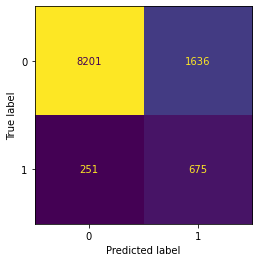

{'0': {'precision': 0.9703028868906768, 'recall': 0.8336891328657111, 'f1-score': 0.8968232270763847, 'support': 9837}, '1': {'precision': 0.292081350064907, 'recall': 0.7289416846652268, 'f1-score': 0.4170528266913809, 'support': 926}, 'accuracy': 0.8246771346278918, 'macro avg': {'precision': 0.6311921184777919, 'recall': 0.781315408765469, 'f1-score': 0.6569380268838828, 'support': 10763}, 'weighted avg': {'precision': 0.9119517633098291, 'recall': 0.8246771346278918, 'f1-score': 0.855545944649876, 'support': 10763}}


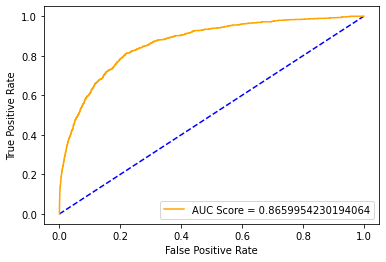

(0.7289416846652268, 0.8659954230194064, 0.8246771346278918)

In [16]:
# Run the above function for a single disease using
create_neural_network_model(df_All_Age,'E11', dataset_names[0],use_subset=False, threshold=0.5)

In [27]:
# #Capture the validation accuracy scores using NN model for all target codes and datasets

# #Define a dictionary
# nn_Classifier_Recall = {}


# for base_code in target_base_codes:
#     i=-1
#     for dataset in datasets_for_modeling:
#             nn_Classifier_Recall[(base_code,dataset_names[i+1])] = \
#             create_neural_network_model(dataset,base_code,dataset_names[i+1],use_subset=False, threshold=0.5)
#             i=i+1
# nn_Classifier_Recall

### Analyzing Time-Bound datasets

In [ ]:
# Load in the medical claims data
medical_claims = pd.read_csv('med_full_final_melted.csv')

# Load in the pharmacy claims data
rx_claims = pd.read_csv('rx_full_final.csv')

In [18]:
# Read in all the timebound datasets
df_TB_E11 = pd.read_csv("E11_with_ages_timebound.csv")
df_TB_N18 = pd.read_csv("N18_with_ages_timebound.csv")
df_TB_I10 = pd.read_csv("I10_with_ages_timebound.csv")
df_TB_I25 = pd.read_csv("I25_with_ages_timebound.csv")
df_TB_C50 = pd.read_csv("C50_with_ages_timebound.csv")
df_TB_C18 = pd.read_csv("C18_with_ages_timebound.csv")

In [19]:
target_base_codes =['E11','N18','I10','I25','C50','C18']

In [20]:
tb_datasets_for_modeling = [df_TB_E11, df_TB_N18, df_TB_I10, df_TB_I25, df_TB_C50, df_TB_C18]
tb_dataset_names=['df_TB_E11', 'df_TB_N18', 'df_TB_I10', 'df_TB_I25','df_TB_C50','df_TB_C18']

In [ ]:
# Capture the recall, auc and accuracy scores using NN model for all timebound target codes and datasets

# #Define a dictionary
# tb_nn_Classifier = {}
# #
# i=-1
# for dataset in tb_datasets_for_modeling:
#     tb_nn_Classifier[(target_base_codes[i+1],tb_dataset_names[i+1])] = \
#     create_neural_network_model(dataset,target_base_codes[i+1],tb_dataset_names[i+1],use_subset=False, threshold=0.3)
#     i=i+1

In [ ]:
#tb_nn_Classifier

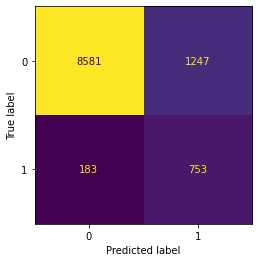

{'0': {'precision': 0.9791191236878137, 'recall': 0.8731176231176231, 'f1-score': 0.9230851979345954, 'support': 9828}, '1': {'precision': 0.3765, 'recall': 0.8044871794871795, 'f1-score': 0.5129427792915531, 'support': 936}, 'accuracy': 0.8671497584541062, 'macro avg': {'precision': 0.6778095618439068, 'recall': 0.8388024013024014, 'f1-score': 0.7180139886130743, 'support': 10764}, 'weighted avg': {'precision': 0.9267174607584386, 'recall': 0.8671497584541062, 'f1-score': 0.8874206397917221, 'support': 10764}}


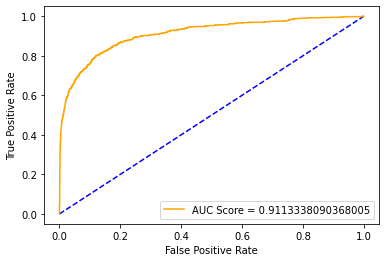

(0.8044871794871795, 0.9113338090368005, 0.8671497584541062)

In [26]:
create_neural_network_model(df_TB_E11,'E11', tb_dataset_names[0],use_subset=False, threshold=0.5)

### Optional Code: To plot training/validation loss or accuracy. You will need to set a validation_split parameter in the tf_model.fit method in the create_neural_network_model function.

In [ ]:
# def plot_training_validation_loss(history, target_code, dataset_name):
#     history_dict = history.history
#     loss_values = history_dict['loss']
#     val_loss_values = history_dict['val_loss']
#     epochs = range(1, len(history_dict['accuracy']) + 1)
#     plt.plot(epochs,loss_values,'bo',label='Training loss')
#     plt.plot(epochs, val_loss_values,'b',label='Validation loss')
#     plt.title('Training and validation loss'+ ' for '+ target_code + ' on '+ dataset_name +' dataset.')
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     plt.legend()
#     plt.show()


In [ ]:
# def plot_training_validation_accuracy(history, target_code, dataset_name):
#     history_dict = history.history
#     history_dict = history.history
#     acc_values = history_dict['accuracy']
#     val_acc_values = history_dict['val_accuracy']
#     epochs = range(1, len(history_dict['accuracy']) + 1)
#     plt.plot(epochs, acc_values, 'bo', label='Training acc')
#     plt.plot(epochs, val_acc_values,'b',label='Validation acc')
#     plt.title('Training and Validation accuracy' + ' for '+ target_code + ' on '+ dataset_name +' dataset.')
#     plt.xlabel('Epochs')
#     plt.ylabel('Accuracy')
#     plt.legend()
#     plt.show()